In [ ]:
import pandas as pd
import numpy as np
from data_columns import childhood, demographic, diagnosis, all
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import umap

/Users/nial/Desktop/Github_Repo/milestone-2-siads-696/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv('./data/mental-health-comorbidity-raw.csv')

In [ ]:
value_groups = defaultdict(list)

for col in diagnosis():
    if col in df.columns:
        unique_vals = frozenset(df[col].dropna().unique())
        value_groups[unique_vals].append(col)

In [ ]:
print("\n🔷 Diagnosis columns with value set [1, 5]:")
one_five_cols = []
for unique_vals, cols in value_groups.items():
    if unique_vals == frozenset([1, 5]):
        one_five_cols.extend(cols)
        for col in cols:
            print(f"  - {col}")


🔷 Diagnosis columns with value set [1, 5]:
  - DSM_ADD
  - DSM_AGO
  - DSM_AGOWO
  - DSM_ALA
  - DSM_ALAH
  - DSM_ALD
  - DSM_ASA
  - DSM_BIPO1
  - DSM_BIPO2
  - DSM_CON
  - DSM_DRA
  - DSM_DRAH
  - DSM_DRD
  - DSM_DYS
  - DSM_DYSH
  - DSM_GAD
  - DSM_GADH
  - DSM_HYP
  - DSM_IED
  - DSM_IEDH
  - DSM_IMJ
  - DSM_IMN
  - DSM_MAN
  - DSM_MJD
  - DSM_MJDH
  - DSM_MND
  - DSM_MNDH
  - DSM_ODD
  - DSM_ODDH
  - DSM_PAT
  - DSM_PD
  - DSM_PD_AGO
  - DSM_PD_WOAGO
  - DSM_PMS
  - DSM_PTSD
  - DSM_SAD
  - DSM_SO
  - DSM_SP
  - DSM_TBD


In [ ]:
print("\n🔶 Diagnosis columns with value set [0, 1, 2] or similar:")
zero_one_two_cols = []
for unique_vals, cols in value_groups.items():
    if unique_vals == frozenset([0, 1, 2]) or (unique_vals.issuperset({1, 2}) and 0 in unique_vals):
        zero_one_two_cols.extend(cols)
        for col in cols:
            print(f"  - {col}")


🔶 Diagnosis columns with value set [0, 1, 2] or similar:
  - DSM_ASP
  - DSM_BOR
  - DSM_PEA
  - DSM_PEC


In [ ]:
one_five_counts = {col: (df[col] == 1).sum() for col in one_five_cols}
zero_one_two_counts = {col: ((df[col] == 1) | (df[col] == 2)).sum() for col in zero_one_two_cols}

top_1_5 = sorted(one_five_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_0_1_2 = sorted(zero_one_two_counts.items(), key=lambda x: x[1], reverse=True)[:10]


In [ ]:
combined_top = []

for col, count in top_1_5:
    combined_top.append((col, "1/5", count))

for col, count in top_0_1_2:
    combined_top.append((col, "0/1/2", count))

combined_top_sorted = sorted(combined_top, key=lambda x: x[2], reverse=True)


In [ ]:
print("\n✅ Top 10 Diagnosis Fields (Sorted by Count):")
for col, coding, count in combined_top_sorted:
    print(f"{col:<30} | Type: {coding:<6} | Count: {count}")



✅ Top 10 Diagnosis Fields (Sorted by Count):
DSM_ASP                        | Type: 0/1/2  | Count: 4085
DSM_PEA                        | Type: 0/1/2  | Count: 3309
DSM_BOR                        | Type: 0/1/2  | Count: 3041
DSM_PEC                        | Type: 0/1/2  | Count: 2724
DSM_TBD                        | Type: 1/5    | Count: 1726
DSM_PAT                        | Type: 1/5    | Count: 1401
DSM_ALA                        | Type: 1/5    | Count: 1212
DSM_MJD                        | Type: 1/5    | Count: 995
DSM_ALAH                       | Type: 1/5    | Count: 960
DSM_SO                         | Type: 1/5    | Count: 808
DSM_MJDH                       | Type: 1/5    | Count: 804
DSM_SP                         | Type: 1/5    | Count: 762
DSM_IED                        | Type: 1/5    | Count: 500
DSM_GAD                        | Type: 1/5    | Count: 472


In [ ]:
#-9,-7 remove
#-6 refuse keep, -8 dont know maybe keep?
def get_filtered_features_for_diagnosis(df, diagnosis_col, positive_values, min_presence=0.3, columns_to_remove=None):
    if isinstance(positive_values, int):
        positive_values = [positive_values]
    if columns_to_remove is None:
        columns_to_remove = []

    diagnosed_df = df[df[diagnosis_col].isin(positive_values)].copy()
    print(f"[Subset] {diagnosed_df.shape[0]} rows match {diagnosis_col} ∈ {positive_values}")

    diagnosed_df.drop(columns=[col for col in columns_to_remove if col in diagnosed_df.columns], inplace=True)

    numeric_df = diagnosed_df.select_dtypes(include=['int64', 'float64'])

    valid_cols = [
        col for col in numeric_df.columns
        if (numeric_df[col] >= 0).mean() >= min_presence
    ]

    final_df = numeric_df[valid_cols]
    print(f"[Filter] {len(valid_cols)} features retained with ≥ {min_presence*100:.0f}% non-negative values")
    return final_df, valid_cols

In [ ]:
admin_cols = ['RESPID', 'NCS1YR', 'AGE', 'STR', 'CASEID', 'COMPLETE', 'SECU', 'CASEWGT']
checkpoint_cols = ['M5A', 'IR3', 'IR11_4', 'IR36', 'IR47', 'PD0A', 'PD2', 'PD5', 'PD14', 'PD20', 'PD23', 'AG2', 'AG7', 'AG10', 
                   'FD4_1', 'FD6', 'FD7_1', 'FD9_1', 'PR1', 'PR11_1', 'PR15', 'FN1', 'FN4', 'FN24', 'CN1_2', 'CN4', 'CN4_1',
                   'CN7_1', 'CN7_2', 'CN8', 'CN14', 'DA36_2B', 'DA36_3A_1', 'DE20_3', 'DE20_6', 'CH23', 'CH38_1', 'CH74_1',
                   'CH104', 'AD0', 'AD2', 'AD7', 'AD29', 'AD31', 'AD36', 'AD43_2', 'OD2', 'OD27', 'CD3', 'CD17_1', 'CD24', 'SA1E_1',
                   'SA2', 'SA3', 'SA7A1', 'SA10', 'SA11E_1', 'SA12', 'SA18_5']
cols_to_remove = admin_cols + checkpoint_cols 

filtered_features, retained_cols = get_filtered_features_for_diagnosis(
    df=df,
    diagnosis_col='DSM_MJD',
    positive_values=1,
    min_presence=0.4,
    columns_to_remove= cols_to_remove  
)

[Subset] 995 rows match DSM_MJD ∈ [1]
[Filter] 356 features retained with ≥ 40% non-negative values


In [ ]:
def run_umap_clustering(df, n_clusters=3, n_components=2, random_state=42):
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    X_embedded = reducer.fit_transform(df)

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    labels = kmeans.fit_predict(X_embedded)

    if n_components == 2:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.title("UMAP Projection with Cluster Labels")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.colorbar(scatter, label="Cluster ID")
        plt.grid(True)
        plt.show()

    return X_embedded, labels

/Users/nial/Desktop/Github_Repo/milestone-2-siads-696/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nial/Desktop/Github_Repo/milestone-2-siads-696/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


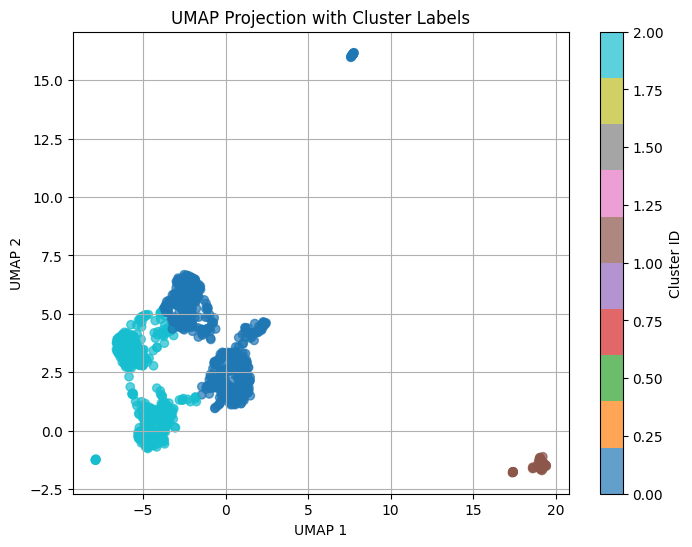

In [ ]:
X_umap, cluster_labels = run_umap_clustering(filtered_features, n_clusters=3)

In [ ]:
def describe_clusters(df_with_labels, cluster_col='cluster', top_n=20):
    cluster_summary = df_with_labels.groupby(cluster_col).mean()

    for cluster_id in cluster_summary.index:
        print(f"\n🔍 Top traits in cluster {cluster_id}:")
        print(cluster_summary.loc[cluster_id].sort_values(ascending=False).head(top_n))

    return cluster_summary

In [ ]:
filtered_features['cluster'] = cluster_labels

cluster_summary = describe_clusters(filtered_features)


🔍 Top traits in cluster 0:
PD4         53.885455
PD18        52.500000
PR4C        20.234545
PR4A        17.783636
CH21        17.223636
CN3         16.761818
DA40        16.076364
FN13        14.287273
CH13        14.052727
DE20        13.583636
DA42        12.650909
PR2         11.901818
FN5         10.058182
CH43         9.845455
CH38         8.325455
FN2INTR1     7.938182
DA38A        5.912727
DA38         5.896364
DA37         5.512727
DA37A        5.318182
Name: 0, dtype: float64

🔍 Top traits in cluster 1:
PD4         985.686275
PD19        199.470588
PD18        140.098039
CH21         16.843137
CN3          15.941176
CH13         14.509804
DA42         13.470588
DE20         12.666667
PR4C         12.568627
DA40         11.843137
FN13         11.117647
PR4A         10.823529
CH43          9.156863
FN5           9.019608
CH38          8.196078
CD9A          7.019608
PR2           7.019608
FN2INTR1      6.215686
DA38          5.176471
DA38A         5.137255
Name: 1, dtype: floa